In [1]:
## Import required packages

import os
import pandas as pd
import kagglehub

from google.colab import files
files.upload()

# Move kaggle.json to the default location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the latest version of the dataset
path = kagglehub.dataset_download("aemreusta/brfss-2020-survey-data")
print("Dataset downloaded to:", path)

data_path = "/root/.cache/kagglehub/datasets/aemreusta/brfss-2020-survey-data/versions/1"
os.listdir(data_path)

file_path = "/root/.cache/kagglehub/datasets/aemreusta/brfss-2020-survey-data/versions/1/brfss2020.csv"
df = pd.read_csv(file_path)

print("Data shape:", df.shape)
df.head()


Saving kaggle.json to kaggle.json


100%|██████████| 48.3M/48.3M [00:00<00:00, 129MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/aemreusta/brfss-2020-survey-data/versions/1
Data shape: (401958, 279)


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
0,1.0,1.0,1042020,1,4,2020,1100.0,2020000001,2.020000e+09,1.0,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0
1,1.0,1.0,2072020,2,7,2020,1200.0,2020000002,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2,1.0,1.0,1232020,1,23,2020,1100.0,2020000003,2.020000e+09,1.0,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0
3,1.0,1.0,1092020,1,9,2020,1100.0,2020000004,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1.0,1.0,1042020,1,4,2020,1100.0,2020000005,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0


In [2]:
## Preprocessing

# 1. Variable Selection & Renaming
# Select columns
df_cols = df[[
    # Psychological factors
    'MENTHLTH', 'ADDEPEV3',

    # Behavioral factors
    'EXERANY2', 'SLEPTIM1', '_RFDRHV7', '_SMOKER3', '_BMI5CAT',

    # Demographic variables
    '_SEX', '_AGE_G', '_IMPRACE', 'EDUCA', '_INCOMG',

    # Cardiovascular outcomes
    'CVDSTRK3', 'CVDCRHD4', 'CVDINFR4'
]]

# Rename variables
df = df_cols.rename(columns={
    'MENTHLTH': 'MentalBadDays',
    'ADDEPEV3': 'DepressionDiag',

    'EXERANY2': 'Exercise',
    'SLEPTIM1': 'SleepTime',
    '_RFDRHV7': 'HeavyDrink',
    '_SMOKER3': 'SmokerStatus',
    '_BMI5CAT': 'BMICat',

    '_SEX': 'Sex',
    '_AGE_G': 'AgeGroup',
    '_IMPRACE': 'Race',
    'EDUCA': 'Education',
    '_INCOMG': 'IncomeGroup',

    'CVDSTRK3': 'Stroke',
    'CVDCRHD4': 'CHD',
    'CVDINFR4': 'MI'
})

# 2. Missing Value Handling (BRFSS Codebook)
import numpy as np

# Codes 7 and 9
missing_7_9 = ['DepressionDiag', 'Exercise', 'Stroke', 'CHD', 'MI']
df[missing_7_9] = df[missing_7_9].replace({7: np.nan, 9: np.nan})

# Code 9
missing_9 = ['HeavyDrink', 'SmokerStatus', 'Education', 'IncomeGroup']
df[missing_9] = df[missing_9].replace({9: np.nan})

# Codes 77 and 99
missing_77_99 = ['MentalBadDays', 'SleepTime']
df[missing_77_99] = df[missing_77_99].replace({77: np.nan, 99: np.nan})

# Code 88 in MentalBadDays = None as 0
df['MentalBadDays'] = df['MentalBadDays'].replace({88: 0})

# Verification
print('Missing Values Verification:')
for col in df.columns:
  print(f'==== {col} ====')
  print(df[col].value_counts(dropna=False).sort_index())

# 3. Outcome Variable: CVD_total
# Initialize column
df['CVD_total'] = np.nan

# Any diagnosed CVD = 1
df.loc[(df['Stroke'] == 1) | (df['CHD'] == 1) | (df['MI'] == 1),'CVD_total'] = 1

# All three conditions absent = 0
df.loc[(df[['Stroke', 'CHD', 'MI']] == 2).all(axis=1), 'CVD_total'] = 0

# Verification
print('Records inconsistent with CVD_total assignment:')
print(df[(df['CVD_total'] == 0) & ((df['Stroke'] == 1) | (df['CHD'] == 1) | (df['MI'] == 1))])
print(df[(df['CVD_total'] == 1) & ((df[['Stroke', 'CHD', 'MI']] == 2).all(axis=1))])

# Confirm counts match original CVD definitions
orig_cvd = df[(df['Stroke'] == 1) | (df['CHD'] == 1) | (df['MI'] == 1)]
print('Original CVD cases:', len(orig_cvd))
print('CVD_total==1 cases:', len(df[df['CVD_total'] == 1]))

# 4. Create EDA Dataset (Complete-Case Outcome)
df_eda = df.dropna(subset=['CVD_total'])
print('df_eda shape:', df_eda.shape)


Missing Values Verification:
==== MentalBadDays ====
MentalBadDays
0.0     255707
1.0      11144
2.0      19591
3.0      12500
4.0       6344
5.0      16705
6.0       1794
7.0       6524
8.0       1314
9.0        252
10.0     12656
11.0       109
12.0       909
13.0       137
14.0      2475
15.0     12006
16.0       189
17.0       159
18.0       255
19.0        24
20.0      6544
21.0       436
22.0       114
23.0        77
24.0        88
25.0      2394
26.0        76
27.0       166
28.0       643
29.0       400
30.0     22297
NaN       7929
Name: count, dtype: int64
==== DepressionDiag ====
DepressionDiag
1.0     75820
2.0    324035
NaN      2103
Name: count, dtype: int64
==== Exercise ====
Exercise
1.0    305883
2.0     95393
NaN       682
Name: count, dtype: int64
==== SleepTime ====
SleepTime
1.0        762
2.0       1102
3.0       2680
4.0       9985
5.0      24431
6.0      82622
7.0     118786
8.0     122257
9.0      19836
10.0      9982
11.0       595
12.0      2865
13.0       14

Number of records in df_eda: 398212
CVD_total
0.0    0.888863
1.0    0.111137
Name: proportion, dtype: float64


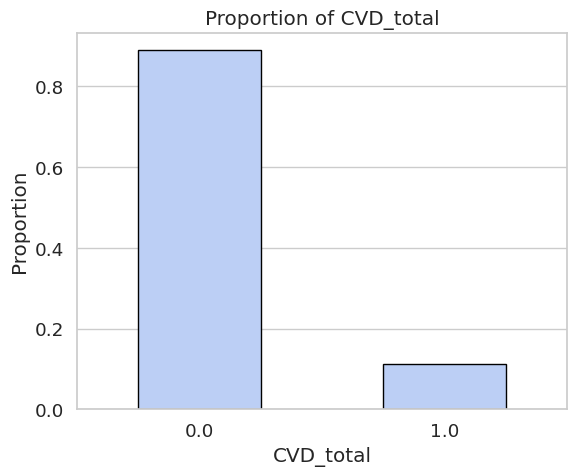

In [3]:
## EDA

# (1) Exploratory Data Analysis: CVD_total
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the outcome variable
print('Number of records in df_eda:', df_eda['CVD_total'].value_counts().sum())
print(df_eda['CVD_total'].value_counts(normalize=True))

# Visualize the proportion of CVD_total
sns.set_theme(style="whitegrid", font_scale=1.2)

cvd_total = df_eda['CVD_total'].value_counts(normalize=True)

x_cvd = cvd_total.index.astype(str)
y_cvd = cvd_total

plt.figure(figsize=(6,5))
sns.barplot(x=x_cvd, y=y_cvd,color="#B2CCFF", edgecolor="black", width=0.5)
plt.xlabel('CVD_total')
plt.ylabel('Proportion')
plt.title('Proportion of CVD_total')
plt.tight_layout()
plt.show()


MentalBadDays
0.0     253525
1.0      11055
2.0      19450
3.0      12409
4.0       6293
5.0      16599
6.0       1777
7.0       6478
8.0       1305
9.0        247
10.0     12550
11.0       104
12.0       899
13.0       134
14.0      2453
15.0     11912
16.0       188
17.0       157
18.0       253
19.0        24
20.0      6481
21.0       429
22.0       114
23.0        76
24.0        86
25.0      2365
26.0        75
27.0       165
28.0       636
29.0       393
30.0     21944
NaN       7636
Name: count, dtype: int64
MentalBadDays(df_eda) values sum: 398212


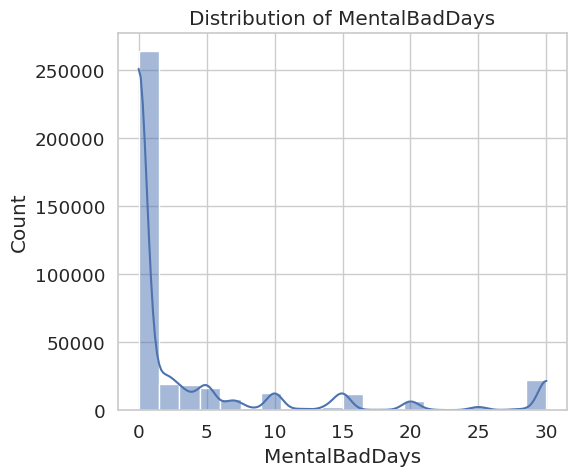

df_mbd shape: (390576, 16)
              count      mean       std  min  25%  50%  75%   max
CVD_total                                                        
0.0        347539.0  3.781668  7.831915  0.0  0.0  0.0  3.0  30.0
1.0         43037.0  4.894161  9.398774  0.0  0.0  0.0  4.0  30.0


/tmp/ipython-input-4143729186.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_mbd, x='CVD_total', y='MentalBadDays', palette='Set2')


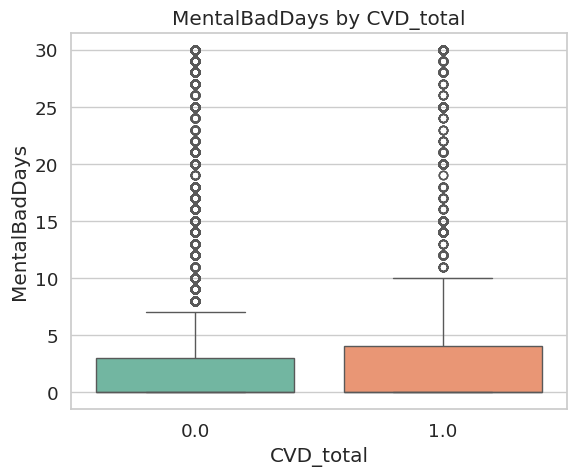

/tmp/ipython-input-4143729186.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_mbd, x='CVD_total', y='MentalBadDays', palette='Set3')


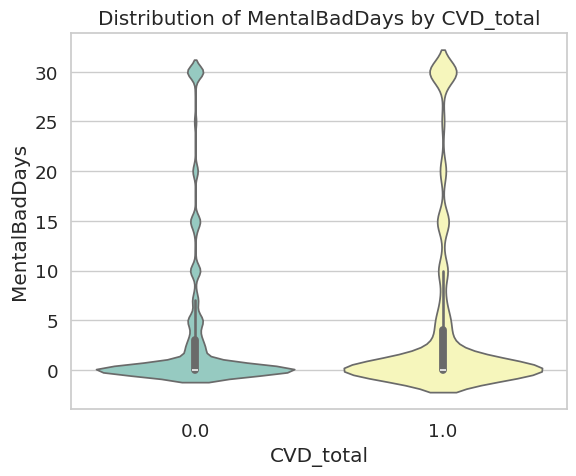

Wilcoxon rank-sum test (MentalBadDays)
U-statistic: 7364695852.0
p-value: 1.4091856283903623e-09
Effect size (rank-biserial correlation): 0.01521987644260081


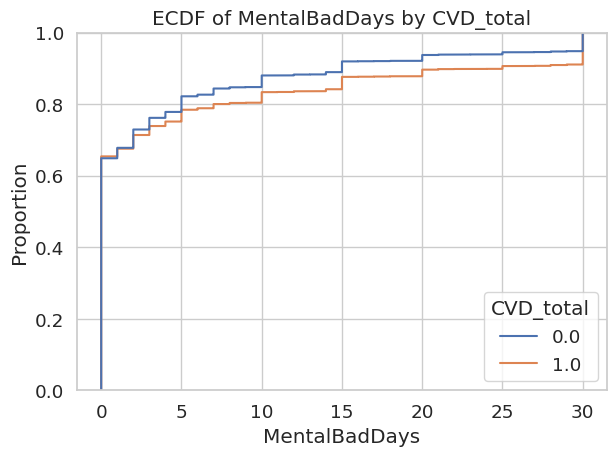

Optimization terminated successfully.
         Current function value: 0.346036
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              CVD_total   No. Observations:               390576
Model:                          Logit   Df Residuals:                   390574
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                0.002519
Time:                        05:15:50   Log-Likelihood:            -1.3515e+05
converged:                       True   LL-Null:                   -1.3549e+05
Covariance Type:            nonrobust   LLR p-value:                1.822e-150
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.1556      0.006   -372.152      0.000      -2.167      -2.144
MentalBadDays     0.

In [4]:
# (2) EDA: Psychological Factors
# 2-1. MentalBadDays
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# 1. Distribution of MentalBadDays
print(df_eda['MentalBadDays'].value_counts(dropna=False).sort_index())
print('MentalBadDays(df_eda) values sum:',
      df_eda['MentalBadDays'].value_counts(dropna=False).sum())

# MentalBadDays barplot (overall distribution)
plt.figure(figsize=(6,5))
sns.histplot(df_eda['MentalBadDays'], bins=20, kde=True)
plt.xlabel('MentalBadDays')
plt.title('Distribution of MentalBadDays')
plt.tight_layout()
plt.show()

# 2. Remove missing values for MentalBadDays
df_mbd = df_eda.dropna(subset=['MentalBadDays'])
print('df_mbd shape:', df_mbd.shape)

# 3. Descriptive statistics by CVD_total
print(df_mbd.groupby('CVD_total')['MentalBadDays'].describe())

# 4. Visualization: CVD prevalence by MentalBadDays
# Boxplot
plt.figure(figsize=(6,5))
sns.boxplot(data=df_mbd, x='CVD_total', y='MentalBadDays', palette='Set2')
plt.ylabel('MentalBadDays')
plt.title('MentalBadDays by CVD_total')
plt.tight_layout()
plt.show()

# Violin plot
plt.figure(figsize=(6,5))
sns.violinplot(data=df_mbd, x='CVD_total', y='MentalBadDays', palette='Set3')
plt.ylabel('MentalBadDays')
plt.title('Distribution of MentalBadDays by CVD_total')
plt.tight_layout()
plt.show()

# 5. Statistical test: Wilcoxon rank-sum (Mann–Whitney U) test
# Compare MentalBadDays between CVD_total = 0 and CVD_total = 1
mbd_c0 = df_mbd[df_mbd['CVD_total'] == 0]['MentalBadDays']
mbd_c1 = df_mbd[df_mbd['CVD_total'] == 1]['MentalBadDays']

# Two-sided test
u_mbd, p_mbd = mannwhitneyu(mbd_c0, mbd_c1, alternative='two-sided')

print("Wilcoxon rank-sum test (MentalBadDays)")
print("U-statistic:", u_mbd)
print("p-value:", p_mbd)

# 6. Effect size: Rank-biserial correlation
mbd_c0_corr = len(mbd_c0)
mbd_c1_corr = len(mbd_c1)

mbd_r = 1 - (2 * u_mbd) / (mbd_c0_corr * mbd_c1_corr)

print("Effect size (rank-biserial correlation):", mbd_r)

# 7. ECDF plot by CVD_total
sns.ecdfplot(data=df_mbd, x='MentalBadDays', hue='CVD_total')
plt.title('ECDF of MentalBadDays by CVD_total')
plt.tight_layout()
plt.show()

# 8. Logistic regression: CVD_total ~ MentalBadDays
df_mbd_logit = df_mbd[df_mbd['CVD_total'].isin([0, 1])].copy()

# Correct data types
df_mbd_logit['CVD_total'] = df_mbd_logit['CVD_total'].astype(int)
df_mbd_logit['MentalBadDays'] = df_mbd_logit['MentalBadDays'].astype(float)

mbd_model = smf.logit("CVD_total ~ MentalBadDays", data=df_mbd_logit).fit()
print(mbd_model.summary())
print("Odds Ratio:", np.exp(mbd_model.params))


DepressionDiag
1.0    0.188156
2.0    0.807444
NaN    0.004400
Name: proportion, dtype: float64
DepressionDiag
1.0     74926
2.0    321534
NaN      1752
Name: count, dtype: int64
DepressionDiag(df_eda) values sum: 398212


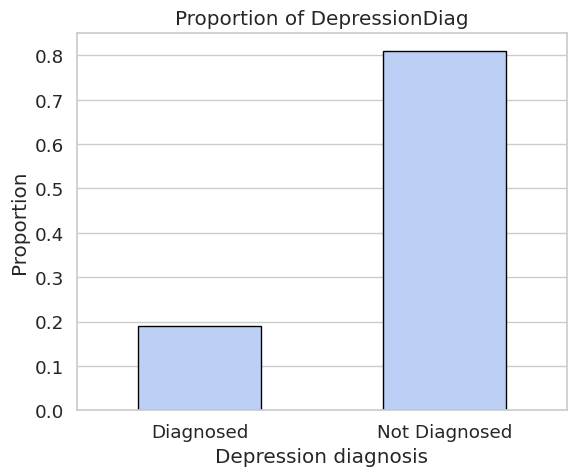

df_dpr shape: (396460, 16)


/tmp/ipython-input-3834528516.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dpr['DepressionDiag_label'] = df_dpr['DepressionDiag'].map({1: 'Yes', 2: 'No'})
/tmp/ipython-input-3834528516.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dpr,x='DepressionDiag_label', y='CVD_total',


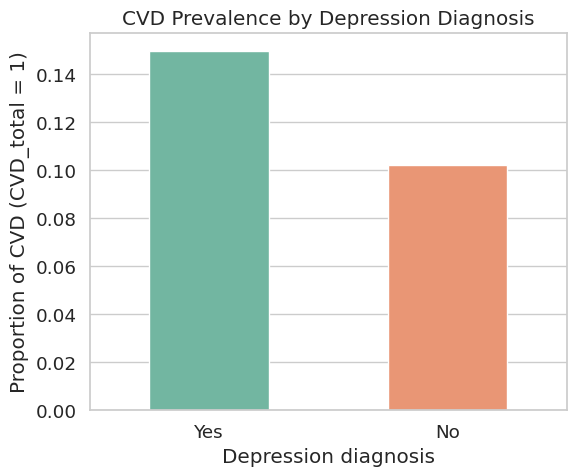

CVD_total                  0.0       1.0
DepressionDiag_label                    
No                    0.898033  0.101967
Yes                   0.850279  0.149721
Chi-square test (DepressionDiag)
Chi2: 1403.862540412768
p-value: 3.0415267103461003e-307
Phi coefficient: 0.059506253026491325
Optimization terminated successfully.
         Current function value: 0.346930
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              CVD_total   No. Observations:               396460
Model:                          Logit   Df Residuals:                   396458
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                0.004747
Time:                        05:15:54   Log-Likelihood:            -1.3754e+05
converged:                       True   LL-Null:                   -1.3820e+05
Covariance Type:            nonrobust   LLR p-value: 

In [5]:
# (2) EDA: Psychological Factors
# 2-2. DepressionDiag

# 1. Distribution of DepressionDiag
print(df_eda['DepressionDiag'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['DepressionDiag'].value_counts(dropna=False).sort_index())
print('DepressionDiag(df_eda) values sum:',
      df_eda['DepressionDiag'].value_counts(dropna=False).sum())

# DepressionDiag histogram (overall distribution)
DepressionDiag = (df_eda['DepressionDiag'].map({1: 'Diagnosed', 2: 'Not Diagnosed'})
    .value_counts(normalize=True).sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=DepressionDiag.index, y=DepressionDiag,
    color='#B2CCFF', edgecolor='black', width=0.5)
plt.xlabel('Depression diagnosis')
plt.ylabel('Proportion')
plt.title('Proportion of DepressionDiag')
plt.tight_layout()
plt.show()

# 2. Remove missing values in DepressionDiag
df_dpr = df_eda.dropna(subset=['DepressionDiag'])
print('df_dpr shape:', df_dpr.shape)

# 3. Visualization: CVD prevalence by DepressionDiag
# Barplot
df_dpr['DepressionDiag_label'] = df_dpr['DepressionDiag'].map({1: 'Yes', 2: 'No'})

plt.figure(figsize=(6, 5))
sns.barplot(data=df_dpr,x='DepressionDiag_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='Set2',width=0.5)
plt.xlabel('Depression diagnosis')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by Depression Diagnosis')
plt.tight_layout()
plt.show()

# 4. Crosstab: DepressionDiag vs. CVD_total
dpr_ct = pd.crosstab(df_dpr['DepressionDiag_label'],df_dpr['CVD_total'],
                     normalize='index')
print(dpr_ct)

# 5. Chi-square test + Phi coefficient
from scipy.stats import chi2_contingency

# Contingency table
dpr_table = pd.crosstab(df_dpr['DepressionDiag'], df_dpr['CVD_total'])
chi2_dpr, p_dpr, dof_dpr, expected_dpr = chi2_contingency(dpr_table)

phi_dpr = np.sqrt(chi2_dpr / df_dpr.shape[0])

print('Chi-square test (DepressionDiag)')
print('Chi2:', chi2_dpr)
print('p-value:', p_dpr)
print('Phi coefficient:', phi_dpr)

# 6. Logistic regression: CVD_total ~ DepressionDiag.
df_dpr_logit = df_dpr[df_dpr['CVD_total'].isin([0, 1])].copy()

# Correct data types
df_dpr_logit['CVD_total'] = df_dpr_logit['CVD_total'].astype(int)
df_dpr_logit['DepressionDiag'] = df_dpr_logit['DepressionDiag'].astype(float)

dpr_model = smf.logit("CVD_total ~ DepressionDiag", data=df_dpr_logit).fit()
print(dpr_model.summary())
print("Odds Ratio:", np.exp(dpr_model.params))


Exercise
1.0    0.762189
2.0    0.236269
NaN    0.001542
Name: proportion, dtype: float64
Exercise
1.0    303513
2.0     94085
NaN       614
Name: count, dtype: int64


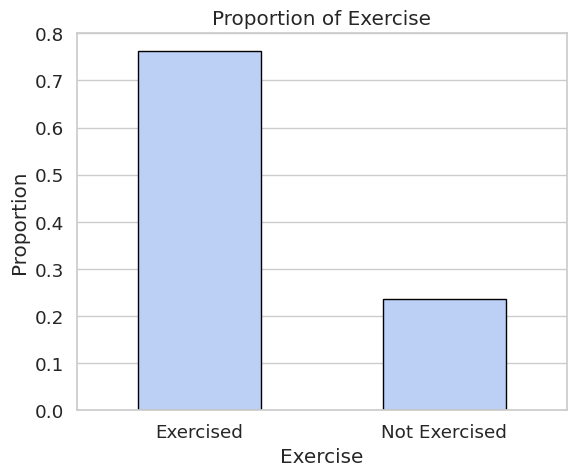

df_ex shape: (397598, 16)


/tmp/ipython-input-2280275967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex['Exercise_label'] = df_ex['Exercise'].map({1: 'Yes', 2: 'No'})
/tmp/ipython-input-2280275967.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ex, x='Exercise_label', y='CVD_total',


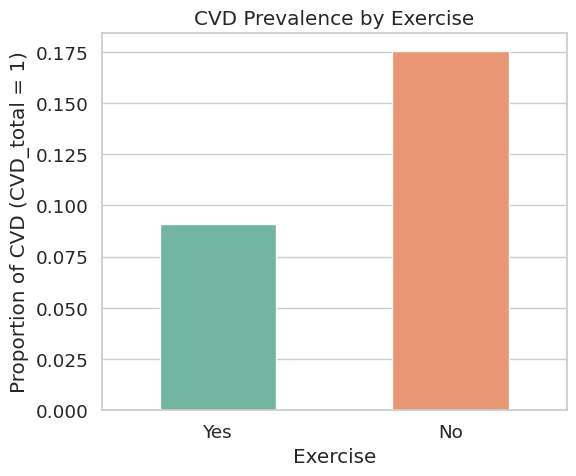

CVD_total            0.0       1.0
Exercise_label                    
No              0.824393  0.175607
Yes             0.909032  0.090968
Chi-square test (Exercise)
Chi2: 5213.278305821563
p-value: 0.0
Phi coefficient: 0.11450734876744378


In [6]:
# (3) EDA: Behaviroal Factors
# 3-1. Exercise

# 1. Distribution of Exercise
print(df_eda['Exercise'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['Exercise'].value_counts(dropna=False).sort_index())

# Exercise barplot (overall distribution)
Exercise = (df_eda['Exercise'].map({1: 'Exercised', 2: 'Not Exercised'})
    .value_counts(normalize=True).sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=Exercise.index, y=Exercise,
    color='#B2CCFF',edgecolor='black',width=0.5)
plt.xlabel('Exercise')
plt.ylabel('Proportion')
plt.title('Proportion of Exercise')
plt.tight_layout()
plt.show()

# 2. Remove missing values in Exercise
df_ex = df_eda.dropna(subset=['Exercise'])
print('df_ex shape:', df_ex.shape)

# 3. Visualization: CVD prevalence by Exercise
# Barplot
df_ex['Exercise_label'] = df_ex['Exercise'].map({1: 'Yes', 2: 'No'})

plt.figure(figsize=(6,5))
sns.barplot(data=df_ex, x='Exercise_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='Set2', width=0.5)
plt.xlabel('Exercise')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by Exercise')
plt.tight_layout()
plt.show()

# 4. Crosstab: Exercise vs. CVD_total
ex_ct = pd.crosstab(df_ex['Exercise_label'], df_ex['CVD_total'], normalize='index')
print(ex_ct)

# 5. Chi-square test + Phi coefficient
# Contingency table
ex_table = pd.crosstab(df_ex['Exercise'], df_ex['CVD_total'])
chi2_ex, p_ex, dof_ex, expected_ex = chi2_contingency(ex_table)

phi_ex = np.sqrt(chi2_ex / df_ex.shape[0])

print('Chi-square test (Exercise)')
print('Chi2:', chi2_ex)
print('p-value:', p_ex)
print('Phi coefficient:', phi_ex)


SleepTime
1.0        746
2.0       1074
3.0       2620
4.0       9830
5.0      24124
6.0      81983
7.0     117938
8.0     121267
9.0      19623
10.0      9854
11.0       583
12.0      2814
13.0       137
14.0       302
15.0       254
16.0       300
17.0        26
18.0       135
19.0         7
20.0        89
21.0         2
22.0        13
23.0         8
24.0        53
NaN       4430
Name: count, dtype: int64
SleepTime(df_eda) values sum: 398212


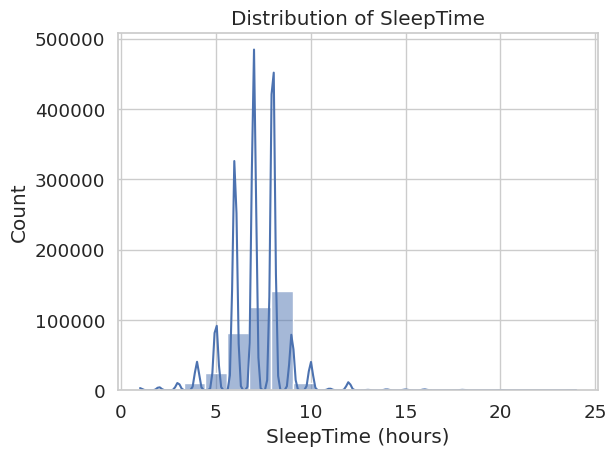

df_slp shape: (393782, 16)
              count      mean       std  min  25%  50%  75%   max
CVD_total                                                        
0.0        350444.0  7.092009  1.407936  1.0  6.0  7.0  8.0  24.0
1.0         43338.0  7.140569  1.848932  1.0  6.0  7.0  8.0  24.0


/tmp/ipython-input-3497878374.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_slp, x='CVD_total', y='SleepTime', palette='Set2')


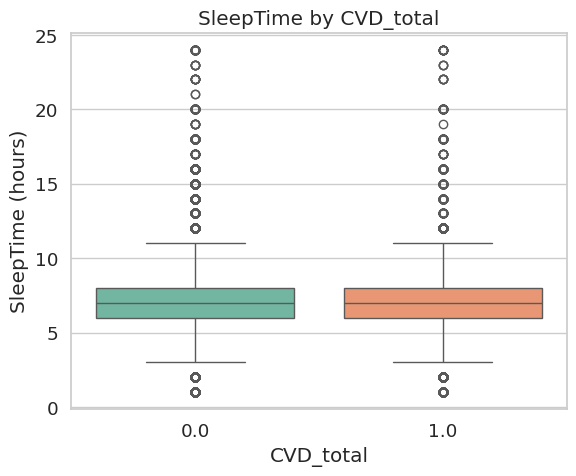

/tmp/ipython-input-3497878374.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_slp, x='CVD_total', y='SleepTime', palette='Set3')


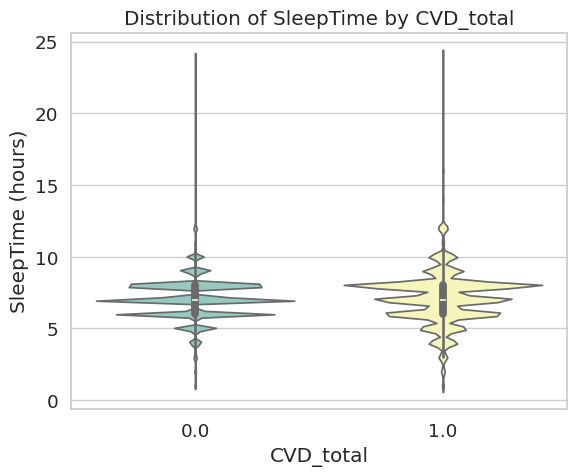

Wilcoxon rank-sum test (SleepTime)
U-statistic: 7478970260.0
p-value: 1.040655899125344e-07
Effect size (rank-biserial correlation): 0.01511775578375496


In [7]:
# (3) EDA: Behaviroal Factors
# 3-2. SleepTime

# 1. Distribution of SleepTime
print(df_eda['SleepTime'].value_counts(dropna=False).sort_index())
print('SleepTime(df_eda) values sum:',
      df_eda['SleepTime'].value_counts(dropna=False).sum())

# SleepTime histogram (overall distribution)
sns.histplot(df_eda['SleepTime'], bins=20, kde=True)
plt.xlabel('SleepTime (hours)')
plt.title('Distribution of SleepTime')
plt.tight_layout()
plt.show()

# 2. Remove missing values for SleepTime
df_slp = df_eda.dropna(subset=['SleepTime'])
print('df_slp shape:', df_slp.shape)

# 3. Descriptive statistics by CVD_total
print(df_slp.groupby('CVD_total')['SleepTime'].describe())

# 4. Visualization: CVD prevalence by SleepTime
# Boxplot
plt.figure(figsize=(6,5))
sns.boxplot(data=df_slp, x='CVD_total', y='SleepTime', palette='Set2')
plt.ylabel('SleepTime (hours)')
plt.title('SleepTime by CVD_total')
plt.tight_layout()
plt.show()

# Violin plot
plt.figure(figsize=(6,5))
sns.violinplot(data=df_slp, x='CVD_total', y='SleepTime', palette='Set3')
plt.ylabel('SleepTime (hours)')
plt.title('Distribution of SleepTime by CVD_total')
plt.tight_layout()
plt.show()

# 5. Statistical test: Wilcoxon rank-sum test (Mann–Whitney U) test
slp_c0 = df_slp[df_slp['CVD_total'] == 0]['SleepTime']
slp_c1 = df_slp[df_slp['CVD_total'] == 1]['SleepTime']

# Two-sided test
u_slp, p_slp = mannwhitneyu(slp_c0, slp_c1, alternative='two-sided')

print("Wilcoxon rank-sum test (SleepTime)")
print("U-statistic:", u_slp)
print("p-value:", p_slp)

# 6. Effect size: Rank-biserial correlation
slp_c0_corr = len(slp_c0)
slp_c1_corr = len(slp_c1)

slp_r = 1 - (2 * u_slp) / (slp_c0_corr * slp_c1_corr)

print("Effect size (rank-biserial correlation):", slp_r)


HeavyDrink
1.0    0.864369
2.0    0.059822
NaN    0.075809
Name: proportion, dtype: float64
HeavyDrink
1.0    344202
2.0     23822
NaN     30188
Name: count, dtype: int64


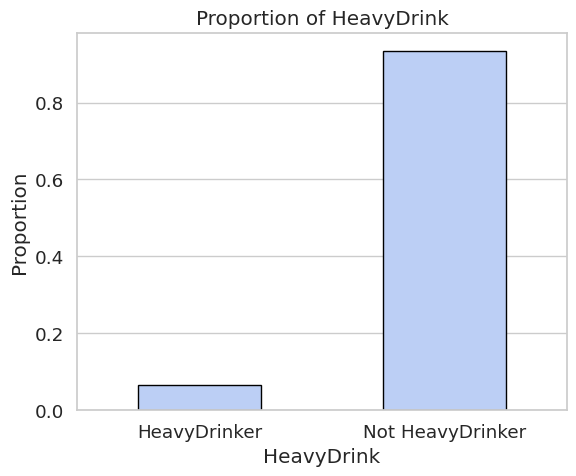

df_hd shape: (368024, 16)


/tmp/ipython-input-3221356487.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hd['HeavyDrink_label'] = df_hd['HeavyDrink'].map({1: 'No', 2: 'Yes'})
/tmp/ipython-input-3221356487.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_hd, x='HeavyDrink_label', y='CVD_total',


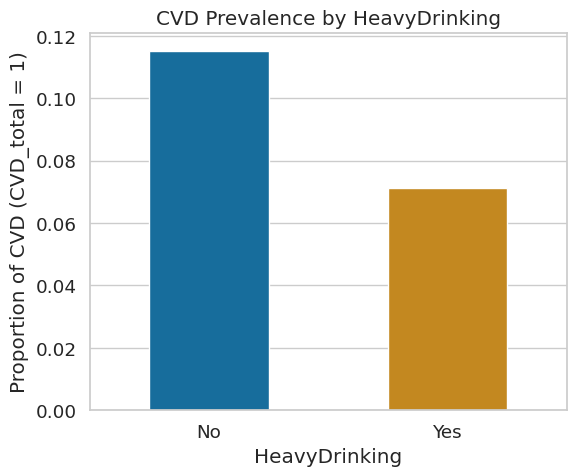

CVD_total              0.0       1.0
HeavyDrink_label                    
No                0.884696  0.115304
Yes               0.928763  0.071237
Chi-square test (HeavyDrink)
Chi2: 433.06724668226883
p-value: 3.4938762526818936e-96
Phi coefficient: 0.03430359203716505


In [8]:
# (3) EDA: Behaviroal Factors
# 3-3. HeavyDrink

# 1. Distribution of HeavyDrink
print(df_eda['HeavyDrink'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['HeavyDrink'].value_counts(dropna=False).sort_index())

# HeavyDrink barplot (overall distribution)
HeavyDrink = (df_eda['HeavyDrink'].map({1: 'Not HeavyDrinker', 2: 'HeavyDrinker'})
    .value_counts(normalize=True).sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=HeavyDrink.index, y=HeavyDrink,
    color='#B2CCFF', edgecolor='black', width=0.5)
plt.xlabel('HeavyDrink')
plt.ylabel('Proportion')
plt.title('Proportion of HeavyDrink')
plt.tight_layout()
plt.show()

# 2. Remove missing values in HeavyDrink
df_hd = df_eda.dropna(subset=['HeavyDrink'])
print('df_hd shape:', df_hd.shape)

# 3. Visualization: CVD prevalence by heavy drinking
# Barplot
df_hd['HeavyDrink_label'] = df_hd['HeavyDrink'].map({1: 'No', 2: 'Yes'})

plt.figure(figsize=(6,5))
sns.barplot(data=df_hd, x='HeavyDrink_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='colorblind', width=0.5)
plt.xlabel('HeavyDrinking')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by HeavyDrinking')
plt.tight_layout()
plt.show()

# 4. Crosstab: HeavyDrink vs. CVD_total
hd_ct = pd.crosstab(df_hd['HeavyDrink_label'], df_hd['CVD_total'],normalize='index')
print(hd_ct)

# 5. Chi-square test + Phi coefficient
# Contingency table
hd_table = pd.crosstab(df_hd['HeavyDrink'], df_hd['CVD_total'])
chi2_hd, p_hd, dof_hd, expected_hd = chi2_contingency(hd_table)

phi_hd = np.sqrt(chi2_hd / df_hd.shape[0])

print('Chi-square test (HeavyDrink)')
print('Chi2:', chi2_hd)
print('p-value:', p_hd)
print('Phi coefficient:', phi_hd)


SmokerStatus
1.0    0.094839
2.0    0.035624
3.0    0.258194
4.0    0.559318
NaN    0.052025
Name: proportion, dtype: float64
SmokerStatus
1.0     37766
2.0     14186
3.0    102816
4.0    222727
NaN     20717
Name: count, dtype: int64


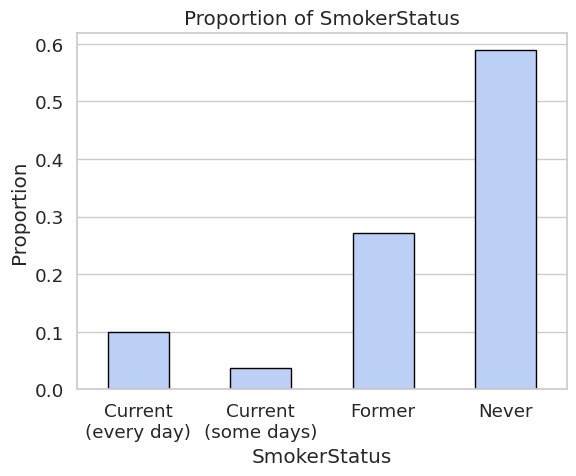

df_smk shape: (377495, 16)


/tmp/ipython-input-1984169855.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smk['SmokerStatus_label'] = df_smk['SmokerStatus'].map({
/tmp/ipython-input-1984169855.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_smk, x='SmokerStatus_label', y='CVD_total',


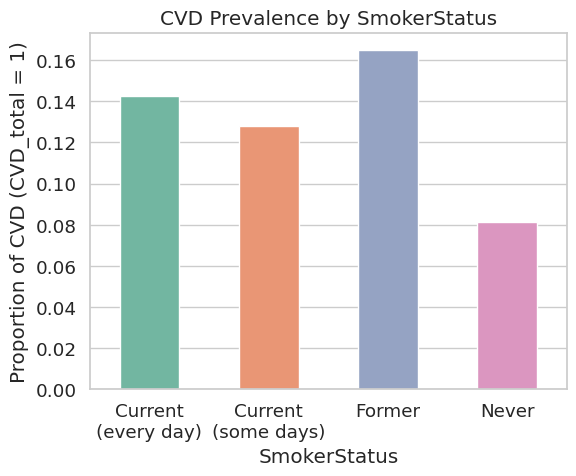

CVD_total                  0.0       1.0
SmokerStatus_label                      
Current\n(every day)  0.857279  0.142721
Current\n(some days)  0.872057  0.127943
Former                0.834899  0.165101
Never                 0.918762  0.081238
Chi-square test (SmokerStatus)
Chi2: 5429.323607264547
p-value: 0.0
Cramers V: 0.11992708071232328


In [9]:
# (3) EDA: Behaviroal Factors
# 3-4. SmokerStatus

# 1. Distribution of SmokerStatus
print(df_eda['SmokerStatus'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['SmokerStatus'].value_counts(dropna=False).sort_index())

# SmokerStatus barplot (overall distribution)
SmokerStatus = (df_eda['SmokerStatus']
    .map({1: 'Current\n(every day)',
        2: 'Current\n(some days)',
        3: 'Former',
        4: 'Never'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=SmokerStatus.index, y=SmokerStatus,
    color='#B2CCFF', edgecolor='black', width=0.5)
plt.xlabel('SmokerStatus')
plt.ylabel('Proportion')
plt.title('Proportion of SmokerStatus')
plt.tight_layout()
plt.show()

# 2. Remove missing values in SmokerStatus
df_smk = df_eda.dropna(subset=['SmokerStatus'])
print('df_smk shape:', df_smk.shape)

# 3. Visualization: CVD prevalence by SmokerStatus
# Barplot
df_smk['SmokerStatus_label'] = df_smk['SmokerStatus'].map({
    1: 'Current\n(every day)', 2: 'Current\n(some days)', 3: 'Former', 4: 'Never'})

plt.figure(figsize=(6,5))
order_smk = ['Current\n(every day)', 'Current\n(some days)', 'Former', 'Never']

sns.barplot(data=df_smk, x='SmokerStatus_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='Set2', width=0.5, order=order_smk)
plt.xlabel('SmokerStatus')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by SmokerStatus')
plt.tight_layout()
plt.show()

# 4. Crosstab: SmokerStatus vs. CVD_total
smk_ct = pd.crosstab(df_smk['SmokerStatus_label'], df_smk['CVD_total'], normalize='index')
print(smk_ct)

# 5. Chi-square test + Cramer's V
# Contingency table
smk_table = pd.crosstab(df_smk['SmokerStatus'], df_smk['CVD_total'])
chi2_smk, p_smk, dof_smk, expected_smk = chi2_contingency(smk_table)

n_smk = df_smk.shape[0]
cramers_v_smk = np.sqrt(chi2_smk / (n_smk * (min(smk_table.shape) - 1)))

print('Chi-square test (SmokerStatus)')
print('Chi2:', chi2_smk)
print('p-value:', p_smk)
print('Cramers V:', cramers_v_smk)


BMICat
1.0    0.014866
2.0    0.274359
3.0    0.321201
4.0    0.287332
NaN    0.102242
Name: proportion, dtype: float64
BMICat
1.0      5920
2.0    109253
3.0    127906
4.0    114419
NaN     40714
Name: count, dtype: int64


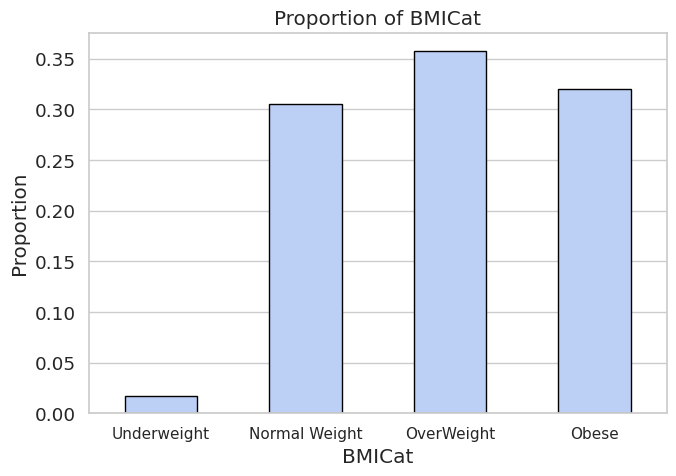

df_bmi shape: (357498, 16)


/tmp/ipython-input-3167919605.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmi['BMICat_label'] = df_bmi['BMICat'].map({
/tmp/ipython-input-3167919605.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bmi, x='BMICat_label', y='CVD_total',


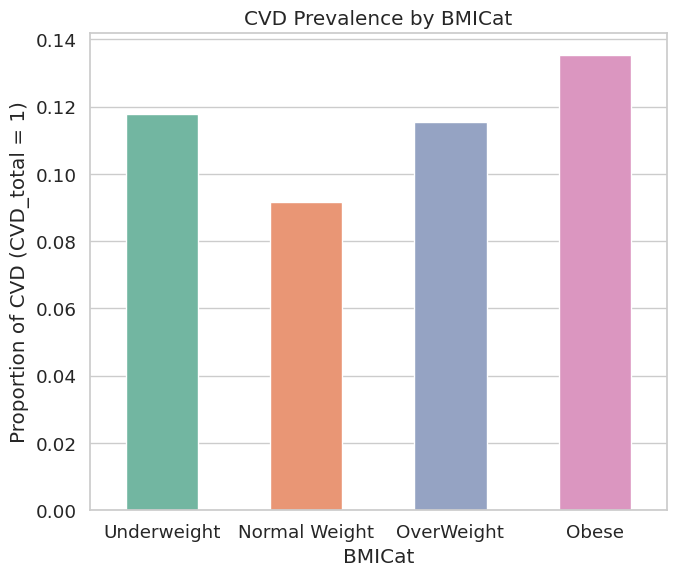

CVD_total           0.0       1.0
BMICat_label                     
Normal Weight  0.908414  0.091586
Obese          0.864751  0.135249
OverWeight     0.884689  0.115311
Underweight    0.882264  0.117736
Chi-square test (BMICat)
Chi2: 1053.2019455386514
p-value: 5.1726253022719637e-228
Cramers V: 0.05427739777660603


In [10]:
# (3) EDA: Behaviroal Factors
# 3-5. BMICat

# 1. Distribution of BMICat
print(df_eda['BMICat'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['BMICat'].value_counts(dropna=False).sort_index())

# BMICat barplot (overall distribution)
BMICat = (df_eda['BMICat']
    .map({1: 'Underweight', 2: 'Normal Weight', 3: 'OverWeight', 4: 'Obese'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(7,5))
sns.barplot(x=BMICat.index, y=BMICat,
    color='#B2CCFF', edgecolor='black', width=0.5,
    order=['Underweight', 'Normal Weight', 'OverWeight', 'Obese'])
plt.xlabel('BMICat')
plt.xticks(fontsize=11)
plt.ylabel('Proportion')
plt.title('Proportion of BMICat')
plt.tight_layout()
plt.show()

# 2. Remove missing values in BMICat
df_bmi = df_eda.dropna(subset=['BMICat'])
print('df_bmi shape:', df_bmi.shape)

# 3. Visualization: CVD prevalence by BMICat
# Barplot
df_bmi['BMICat_label'] = df_bmi['BMICat'].map({
    1: 'Underweight', 2: 'Normal Weight', 3: 'OverWeight', 4: 'Obese'})

plt.figure(figsize=(7,6))
order_bmi = ['Underweight', 'Normal Weight', 'OverWeight', 'Obese']

sns.barplot(data=df_bmi, x='BMICat_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='Set2', width=0.5, order=order_bmi)
plt.xlabel('BMICat')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by BMICat')
plt.tight_layout()
plt.show()

# 4. Crosstab: BMICat vs. CVD_total
bmi_ct = pd.crosstab(df_bmi['BMICat_label'], df_bmi['CVD_total'], normalize='index')
print(bmi_ct)

# 5. Chi-square test + Cramer's V
# Contingency table
bmi_table = pd.crosstab(df_bmi['BMICat'], df_bmi['CVD_total'])
chi2_bmi, p_bmi, dof_bmi, expected_bmi = chi2_contingency(bmi_table)

n_bmi = df_bmi.shape[0]
cramers_v_bmi = np.sqrt(chi2_bmi / (n_bmi * (min(bmi_table.shape) - 1)))

print('Chi-square test (BMICat)')
print('Chi2:', chi2_bmi)
print('p-value:', p_bmi)
print('Cramers V:', cramers_v_bmi)


Sex
1.0    0.457143
2.0    0.542857
Name: proportion, dtype: float64
Sex
1.0    182040
2.0    216172
Name: count, dtype: int64


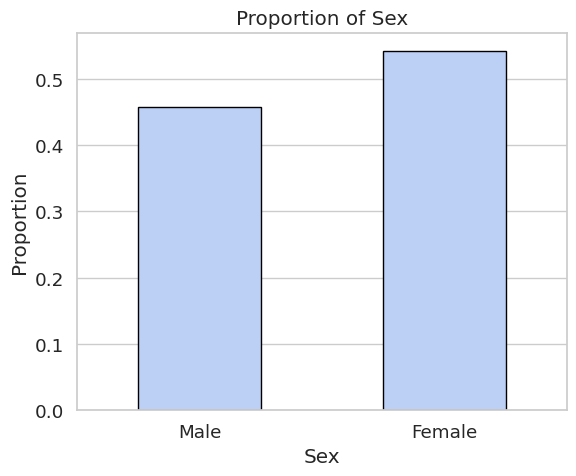

/tmp/ipython-input-2208550212.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sex, x='Sex_label', y='CVD_total',


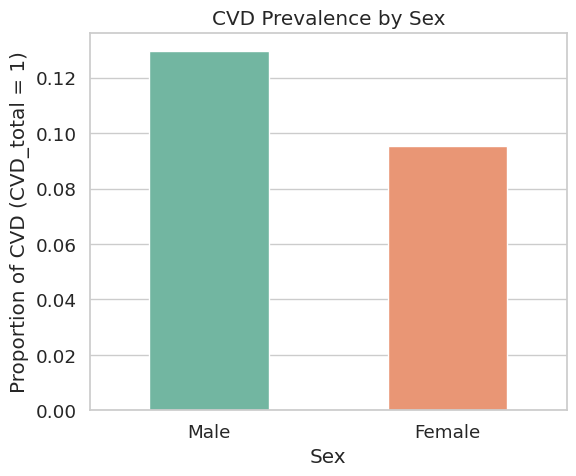

CVD_total       0.0       1.0
Sex                          
1.0        0.870215  0.129785
2.0        0.904567  0.095433
Chi-square test (Sex)
Chi2: 1180.1033059226204
p-value: 1.2865773203378234e-258
Phi coefficient: 0.05443808531487807


In [11]:
# (4) EDA: Demographic factors
# 4-1. Sex

# 1. Distribution of Sex
print(df_eda['Sex'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['Sex'].value_counts(dropna=False).sort_index())

# Exercise barplot (overall distribution)
Sex = (df_eda['Sex'].map({1: 'Male', 2: 'Female'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=Sex.index, y=Sex,
    color='#B2CCFF', edgecolor='black', width=0.5,
    order=['Male', 'Female'])
plt.xlabel('Sex')
plt.ylabel('Proportion')
plt.title('Proportion of Sex')
plt.tight_layout()
plt.show()

# 2. Visualization: CVD prevalence by Sex
# Barplot
df_sex = df_eda.copy()
df_sex['Sex_label'] = df_sex['Sex'].map({1: 'Male', 2: 'Female'})

plt.figure(figsize=(6,5))
order_sex = ['Male', 'Female']

sns.barplot(data=df_sex, x='Sex_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='Set2', width=0.5, order=order_sex)
plt.xlabel('Sex')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by Sex')
plt.tight_layout()
plt.show()

# 3. Crosstab: Sex vs. CVD_total
sex_ct = pd.crosstab(df_sex['Sex'], df_sex['CVD_total'], normalize='index')
print(sex_ct)

# 4. Chi-square test + Phi coefficient
# Contingency table
sex_table = pd.crosstab(df_sex['Sex'], df_sex['CVD_total'])
chi2_sex, p_sex, dof_sex, expected_sex = chi2_contingency(sex_table)

phi_sex = np.sqrt(chi2_sex / df_sex.shape[0])

print('Chi-square test (Sex)')
print('Chi2:', chi2_sex)
print('p-value:', p_sex)
print('Phi coefficient:', phi_sex)


Sex
1.0    0.457143
2.0    0.542857
Name: proportion, dtype: float64
Sex
1.0    182040
2.0    216172
Name: count, dtype: int64


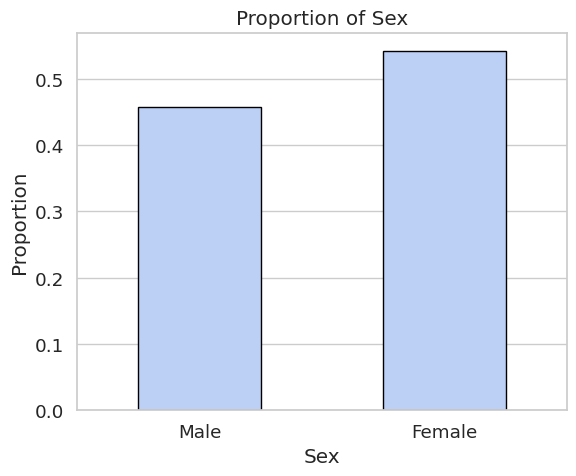

/tmp/ipython-input-2208550212.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sex, x='Sex_label', y='CVD_total',


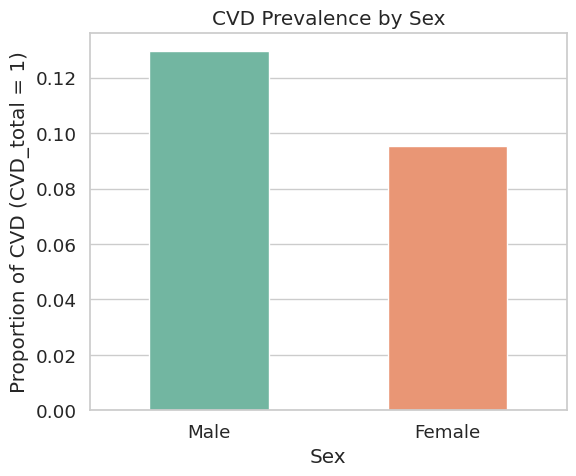

CVD_total       0.0       1.0
Sex                          
1.0        0.870215  0.129785
2.0        0.904567  0.095433
Chi-square test (Sex)
Chi2: 1180.1033059226204
p-value: 1.2865773203378234e-258
Phi coefficient: 0.05443808531487807


In [12]:
# (4) EDA: Demographic factors
# 4-1. Sex

# 1. Distribution of Sex
print(df_eda['Sex'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['Sex'].value_counts(dropna=False).sort_index())

# Exercise barplot (overall distribution)
Sex = (df_eda['Sex'].map({1: 'Male', 2: 'Female'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=Sex.index, y=Sex,
    color='#B2CCFF', edgecolor='black', width=0.5,
    order=['Male', 'Female'])
plt.xlabel('Sex')
plt.ylabel('Proportion')
plt.title('Proportion of Sex')
plt.tight_layout()
plt.show()

# 2. Visualization: CVD prevalence by Sex
# Barplot
df_sex = df_eda.copy()
df_sex['Sex_label'] = df_sex['Sex'].map({1: 'Male', 2: 'Female'})

plt.figure(figsize=(6,5))
order_sex = ['Male', 'Female']

sns.barplot(data=df_sex, x='Sex_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x), errorbar=None,
    palette='Set2', width=0.5, order=order_sex)
plt.xlabel('Sex')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by Sex')
plt.tight_layout()
plt.show()

# 3. Crosstab: Sex vs. CVD_total
sex_ct = pd.crosstab(df_sex['Sex'], df_sex['CVD_total'], normalize='index')
print(sex_ct)

# 4. Chi-square test + Phi coefficient
# Contingency table
sex_table = pd.crosstab(df_sex['Sex'], df_sex['CVD_total'])
chi2_sex, p_sex, dof_sex, expected_sex = chi2_contingency(sex_table)

phi_sex = np.sqrt(chi2_sex / df_sex.shape[0])

print('Chi-square test (Sex)')
print('Chi2:', chi2_sex)
print('p-value:', p_sex)
print('Phi coefficient:', phi_sex)


AgeGroup
1.0    0.064129
2.0    0.110896
3.0    0.129755
4.0    0.154433
5.0    0.194504
6.0    0.346283
Name: proportion, dtype: float64
AgeGroup
1.0     25537
2.0     44160
3.0     51670
4.0     61497
5.0     77454
6.0    137894
Name: count, dtype: int64


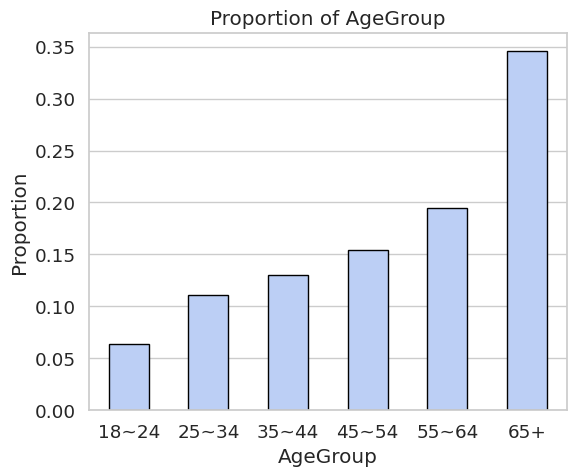

/tmp/ipython-input-1718155955.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ag, x='AgeGroup_label', y='CVD_total',


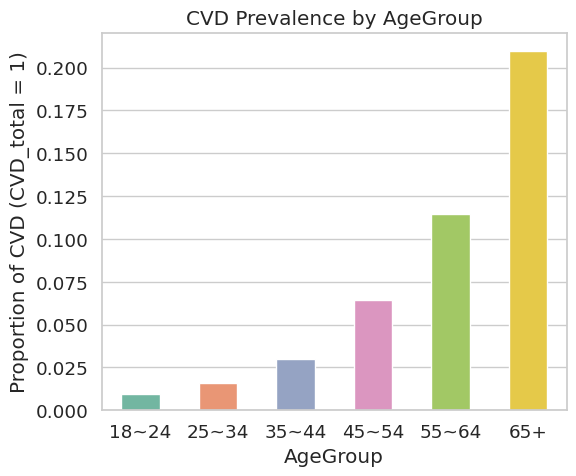

CVD_total            0.0       1.0
AgeGroup_label                    
18~24           0.990328  0.009672
25~34           0.983922  0.016078
35~44           0.970099  0.029901
45~54           0.935720  0.064280
55~64           0.885700  0.114300
65+             0.790071  0.209929
Chi-square test (AgeGroup)
Chi2: 25151.12253274087
p-value: 0.0
Cramers V: 0.25131679633967857


In [13]:
# (4) EDA: Demographic factors
# 4-2. AgeGroup

# 1. Distribution of AgeGroup
print(df_eda['AgeGroup'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['AgeGroup'].value_counts(dropna=False).sort_index())

# AgeGroup barplot (overall distribution)
AgeGroup = (df_eda['AgeGroup']
    .map({1: '18~24', 2: '25~34', 3: '35~44', 4: '45~54', 5: '55~64', 6: '65+'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(6,5))
sns.barplot(x=AgeGroup.index, y=AgeGroup,
    color='#B2CCFF', edgecolor='black', width=0.5)
plt.xlabel('AgeGroup')
plt.ylabel('Proportion')
plt.title('Proportion of AgeGroup')
plt.tight_layout()
plt.show()

# 2. Visualization: CVD prevalence by AgeGroup
# Barplot
df_ag = df_eda.copy()
df_ag['AgeGroup_label'] = df_ag['AgeGroup'].map({
    1: '18~24',  2: '25~34', 3: '35~44', 4: '45~54', 5: '55~64', 6: '65+'})

plt.figure(figsize=(6,5))
order_ag = ['18~24', '25~34', '35~44', '45~54', '55~64', '65+']

sns.barplot(data=df_ag, x='AgeGroup_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x),
    errorbar=None, palette='Set2', width=0.5, order=order_ag)
plt.xlabel('AgeGroup')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by AgeGroup')
plt.tight_layout()
plt.show()


# 3. Crosstab: AgeGroup vs. CVD_total
ag_ct = pd.crosstab(df_ag['AgeGroup_label'], df_ag['CVD_total'], normalize='index')
print(ag_ct)

# 4. Chi-square test + Cramer's V
# Contingency table
ag_table = pd.crosstab(df_ag['AgeGroup'], df_ag['CVD_total'])
chi2_ag, p_ag, dof_ag, expected_ag = chi2_contingency(ag_table)

n_ag = df_ag.shape[0]
cramers_v_ag = np.sqrt(chi2_ag / (n_ag * (min(ag_table.shape) - 1)))

print('Chi-square test (AgeGroup)')
print('Chi2:', chi2_ag)
print('p-value:', p_ag)
print('Cramers V:', cramers_v_ag)


Race
1.0    0.756476
2.0    0.075497
3.0    0.025383
4.0    0.017184
5.0    0.090517
6.0    0.034941
Name: proportion, dtype: float64
Race
1.0    301238
2.0     30064
3.0     10108
4.0      6843
5.0     36045
6.0     13914
Name: count, dtype: int64


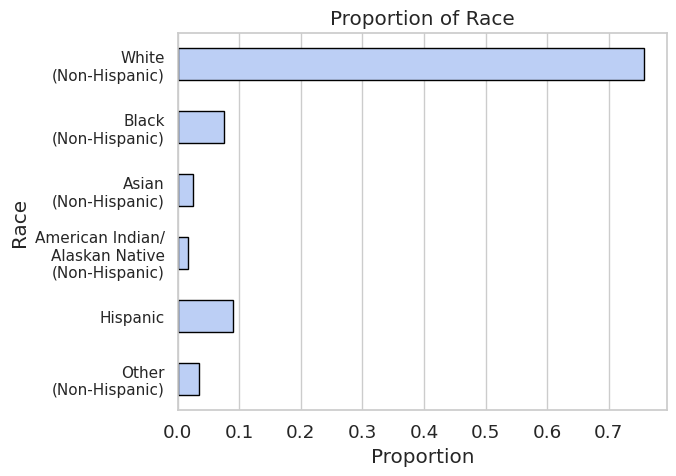

/tmp/ipython-input-424160889.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_rc, y='Race_label', x='CVD_total',


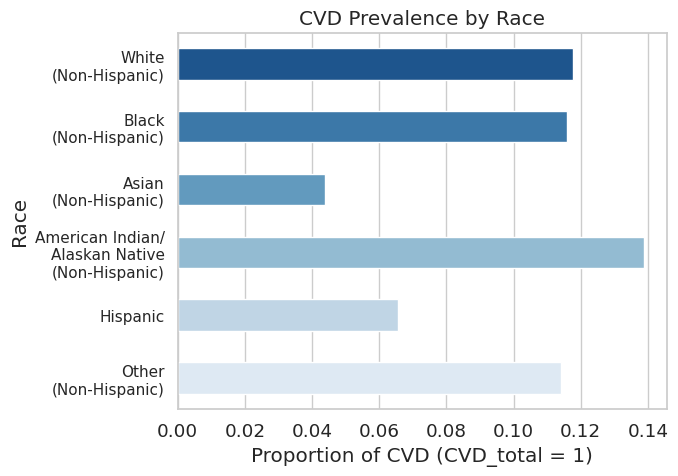

CVD_total                                              0.0       1.0
Race_label                                                          
American Indian/\nAlaskan Native\n(Non-Hispanic)  0.861318  0.138682
Asian\n(Non-Hispanic)                             0.956074  0.043926
Black\n(Non-Hispanic)                             0.884047  0.115953
Hispanic                                          0.934499  0.065501
Other\n(Non-Hispanic)                             0.885870  0.114130
White\n(Non-Hispanic)                             0.882392  0.117608
Chi-square test (Race)
Chi2: 1410.7019034638859
p-value: 6.604938621235969e-303
Cramers V: 0.05951966176458149


In [14]:
# (4) EDA: Demographic factors
# 4-3. Race

# 1. Distribution of Race
print(df_eda['Race'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['Race'].value_counts(dropna=False).sort_index())

# Race barplot (overall distribution)
Race = (
    df_eda['Race']
    .map({1: 'White\n(Non-Hispanic)',
        2: 'Black\n(Non-Hispanic)',
        3: 'Asian\n(Non-Hispanic)',
        4: 'American Indian/\nAlaskan Native\n(Non-Hispanic)',
        5: 'Hispanic',
        6: 'Other\n(Non-Hispanic)'})
    .value_counts(normalize=True).sort_index())

plt.figure(figsize=(7,5))
sns.barplot(y=Race.index, x=Race,
    color='#B2CCFF', edgecolor='black', width=0.5,
    order=['White\n(Non-Hispanic)',
        'Black\n(Non-Hispanic)',
        'Asian\n(Non-Hispanic)',
        'American Indian/\nAlaskan Native\n(Non-Hispanic)',
        'Hispanic',
        'Other\n(Non-Hispanic)'])
plt.xlabel('Proportion')
plt.ylabel('Race')
plt.yticks(fontsize=11)
plt.title('Proportion of Race')
plt.tight_layout()
plt.show()

# 2. Visualization: CVD prevalence by Race
# Barplot
df_rc = df_eda.copy()
df_rc['Race_label'] = df_rc['Race'].map({
    1: 'White\n(Non-Hispanic)',
    2: 'Black\n(Non-Hispanic)',
    3: 'Asian\n(Non-Hispanic)',
    4: 'American Indian/\nAlaskan Native\n(Non-Hispanic)',
    5: 'Hispanic',
    6: 'Other\n(Non-Hispanic)'})

plt.figure(figsize=(7,5))
order_rc = ['White\n(Non-Hispanic)',
            'Black\n(Non-Hispanic)',
            'Asian\n(Non-Hispanic)',
            'American Indian/\nAlaskan Native\n(Non-Hispanic)',
            'Hispanic',
            'Other\n(Non-Hispanic)']

sns.barplot(data=df_rc, y='Race_label', x='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x),
    errorbar=None, palette='Blues_r', width=0.5, order=order_rc)
plt.xlabel('Proportion of CVD (CVD_total = 1)')
plt.ylabel('Race')
plt.yticks(fontsize=11)
plt.title('CVD Prevalence by Race')
plt.tight_layout()
plt.show()

# 3. Crosstab: Race vs. CVD_total
rc_ct = pd.crosstab(df_rc['Race_label'], df_rc['CVD_total'], normalize='index')
print(rc_ct)

# 4. Chi-square test + Cramer's V
# Contingency table
rc_table = pd.crosstab(df_rc['Race'], df_rc['CVD_total'])
chi2_rc, p_rc, dof_rc, expected_rc = chi2_contingency(rc_table)

n_rc = df_rc.shape[0]
cramers_v_rc = np.sqrt(chi2_rc / (n_rc * (min(rc_table.shape) - 1)))

print('Chi-square test (Race)')
print('Chi2:', chi2_rc)
print('p-value:', p_rc)
print('Cramers V:', cramers_v_rc)


Education
1.0    0.001361
2.0    0.019856
3.0    0.043391
4.0    0.265976
5.0    0.277405
6.0    0.387560
NaN    0.004450
Name: proportion, dtype: float64
Education
1.0       542
2.0      7907
3.0     17279
4.0    105915
5.0    110466
6.0    154331
NaN      1772
Name: count, dtype: int64


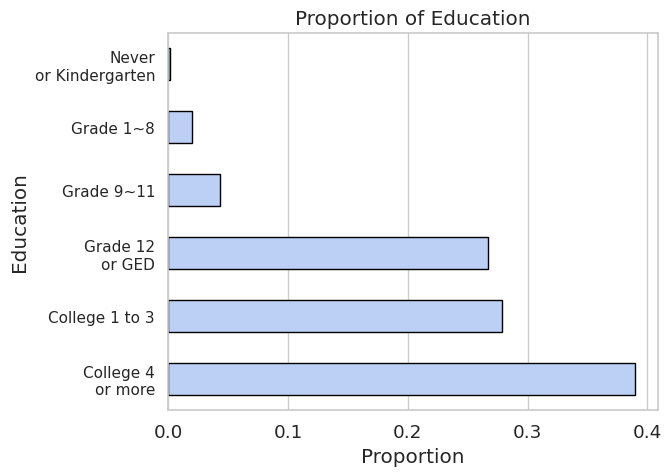

df_edu shape: (396440, 16)


/tmp/ipython-input-2927729852.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edu['Education_label'] = df_edu['Education'].map({
/tmp/ipython-input-2927729852.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


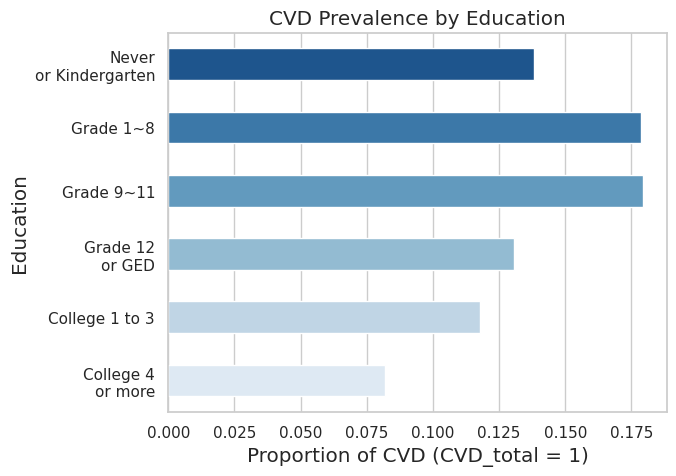

CVD_total                    0.0       1.0
Education_label                           
College 1 to 3          0.882244  0.117756
College 4\nor more      0.918085  0.081915
Grade 12\nor GED        0.869480  0.130520
Grade 1~8               0.821424  0.178576
Grade 9~11              0.820591  0.179409
Never\nor Kindergarten  0.861624  0.138376
Chi-square test (Education)
Chi2: 2969.148587327293
p-value: 0.0
Cramers V: 0.08654206069837098


In [15]:
# (4) EDA: Demographic factors
# 4-4. Education

# 1. Distribution of Education
print(df_eda['Education'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['Education'].value_counts(dropna=False).sort_index())

# Education barplot (overall distribution)
Education = (df_eda['Education']
    .map({ 1: 'Never\nor Kindergarten', 2: 'Grade 1~8',
    3: 'Grade 9~11', 4: 'Grade 12\nor GED',
    5: 'College 1 to 3', 6: 'College 4\nor more'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(7,5))
sns.barplot(y=Education.index, x=Education,
    color='#B2CCFF', edgecolor='black', width=0.5,
    order=['Never\nor Kindergarten', 'Grade 1~8', 'Grade 9~11',
        'Grade 12\nor GED', 'College 1 to 3', 'College 4\nor more'])
plt.xlabel('Proportion')
plt.ylabel('Education')
plt.yticks(fontsize=11)
plt.title('Proportion of Education')
plt.tight_layout()
plt.show()

# 2. Remove missing values in Education
df_edu = df_eda.dropna(subset=['Education'])
print('df_edu shape:', df_edu.shape)

# 3. Visualization: CVD prevalence by Education
# Barplot
df_edu['Education_label'] = df_edu['Education'].map({
    1: 'Never\nor Kindergarten', 2: 'Grade 1~8',
    3: 'Grade 9~11', 4: 'Grade 12\nor GED',
    5: 'College 1 to 3', 6: 'College 4\nor more'})

plt.figure(figsize=(7,5))
order_edu = ['Never\nor Kindergarten', 'Grade 1~8','Grade 9~11',
             'Grade 12\nor GED','College 1 to 3','College 4\nor more']

sns.barplot(
    data=df_edu, y='Education_label', x='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x),
    errorbar=None, palette='Blues_r', width=0.5, order=order_edu
)
plt.xlabel('Proportion of CVD (CVD_total = 1)')
plt.xticks(fontsize=11)
plt.ylabel('Education')
plt.yticks(fontsize=11)
plt.title('CVD Prevalence by Education')
plt.tight_layout()
plt.show()

# 4. Crosstab: Education vs. CVD_total
edu_ct = pd.crosstab(df_edu['Education_label'], df_edu['CVD_total'], normalize='index')
print(edu_ct)

# 5. Chi-square test + Cramer's V
# Contingency table
edu_table = pd.crosstab(df_edu['Education'], df_edu['CVD_total'])
chi2_edu, p_edu, dof_edu, expected_edu = chi2_contingency(edu_table)

n_edu = df_edu.shape[0]
cramers_v_edu = np.sqrt(chi2_edu / (n_edu * (min(edu_table.shape) - 1)))

print('Chi-square test (Education)')
print('Chi2:', chi2_edu)
print('p-value:', p_edu)
print('Cramers V:', cramers_v_edu)


IncomeGroup
1.0    0.065704
2.0    0.121023
3.0    0.078024
4.0    0.109351
5.0    0.428340
NaN    0.197558
Name: proportion, dtype: float64
IncomeGroup
1.0     26164
2.0     48193
3.0     31070
4.0     43545
5.0    170570
NaN     78670
Name: count, dtype: int64


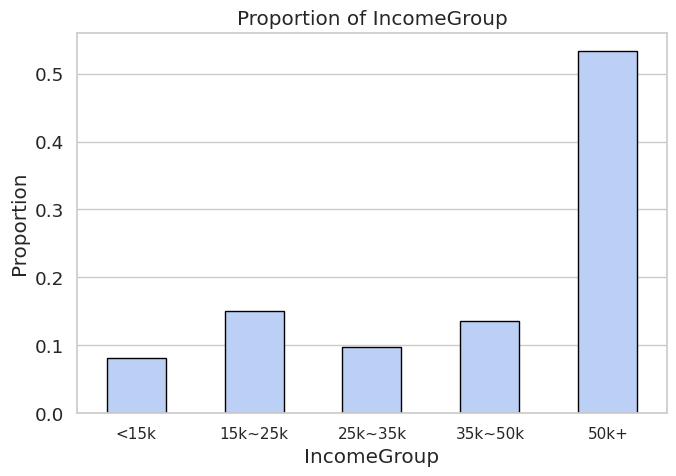

df_inc shape: (319542, 16)


/tmp/ipython-input-3681897976.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inc['IncomeGroup_label'] = df_inc['IncomeGroup'].map({
/tmp/ipython-input-3681897976.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_inc, x='IncomeGroup_label', y='CVD_total',


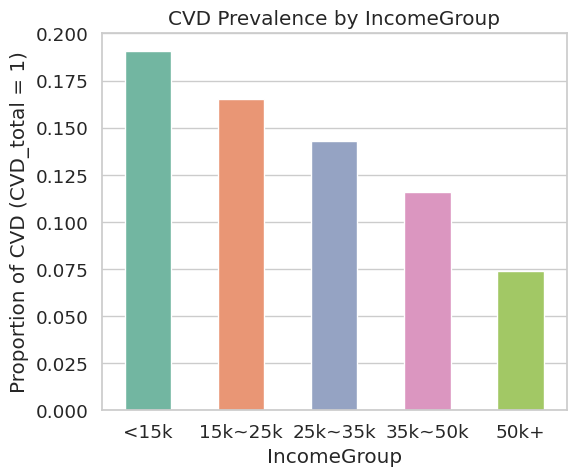

CVD_total               0.0       1.0
IncomeGroup_label                    
15k~25k            0.834831  0.165169
25k~35k            0.857290  0.142710
35k~50k            0.883982  0.116018
50k+               0.926036  0.073964
<15k               0.809089  0.190911
Chi-square test (IncomeGroup)
Chi2: 5879.4172930337045
p-value: 0.0
Cramers V: 0.13564480581358146


In [16]:
# (4) EDA: Demographic factors
# 4-5. IncomeGroup

# 1. Distribution of IncomeGroup
print(df_eda['IncomeGroup'].value_counts(dropna=False, normalize=True).sort_index())
print(df_eda['IncomeGroup'].value_counts(dropna=False).sort_index())

# IncomeGroup barplot (overall distribution)
IncomeGroup = (df_eda['IncomeGroup']
    .map({1: '<15k', 2: '15k~25k', 3: '25k~35k', 4: '35k~50k', 5: '50k+'})
    .value_counts(normalize=True)
    .sort_index())

plt.figure(figsize=(7,5))
sns.barplot(x=IncomeGroup.index, y=IncomeGroup,
    color='#B2CCFF', edgecolor='black', width=0.5,
    order=['<15k', '15k~25k', '25k~35k', '35k~50k', '50k+'])
plt.xlabel('IncomeGroup')
plt.xticks(fontsize=11)
plt.ylabel('Proportion')
plt.title('Proportion of IncomeGroup')
plt.tight_layout()
plt.show()

# 2. Remove missing values in IncomeGroup
df_inc = df_eda.dropna(subset=['IncomeGroup'])
print('df_inc shape:', df_inc.shape)

# 3. Visualization: CVD prevalence by IncomeGroup
# Barplot
df_inc['IncomeGroup_label'] = df_inc['IncomeGroup'].map({
    1: '<15k', 2: '15k~25k', 3: '25k~35k', 4: '35k~50k', 5: '50k+'})

plt.figure(figsize=(6,5))
order_inc = ['<15k', '15k~25k', '25k~35k', '35k~50k', '50k+']

sns.barplot(data=df_inc, x='IncomeGroup_label', y='CVD_total',
    estimator=lambda x: sum(x == 1) / len(x),
    errorbar=None, palette='Set2', width=0.5, order=order_inc)
plt.xlabel('IncomeGroup')
plt.ylabel('Proportion of CVD (CVD_total = 1)')
plt.title('CVD Prevalence by IncomeGroup')
plt.tight_layout()
plt.show()

# 4. Crosstab: IncomeGroup vs. CVD_total
inc_ct = pd.crosstab(df_inc['IncomeGroup_label'], df_inc['CVD_total'], normalize='index')
print(inc_ct)

# 5. Chi-square test + Cramer's V
# Contingency table
inc_table = pd.crosstab(df_inc['IncomeGroup'], df_inc['CVD_total'])
chi2_inc, p_inc, dof_inc, expected_inc = chi2_contingency(inc_table)

n_inc = df_inc.shape[0]
cramers_v_inc = np.sqrt(chi2_inc / (n_inc * (min(inc_table.shape) - 1)))

print('Chi-square test (IncomeGroup)')
print('Chi2:', chi2_inc)
print('p-value:', p_inc)
print('Cramers V:', cramers_v_inc)


IncomeGroup_label        15k~25k   25k~35k   35k~50k      50k+      <15k
Education_label                                                         
College 1 to 3          0.162808  0.115419  0.162079  0.482012  0.077682
College 4\nor more      0.062099  0.055366  0.108566  0.747972  0.025996
Grade 12\nor GED        0.234060  0.136808  0.162221  0.345504  0.121406
Grade 1~8               0.350414  0.120280  0.072456  0.084142  0.372708
Grade 9~11              0.336198  0.128300  0.101123  0.151839  0.282540
Never\nor Kindergarten  0.295181  0.123494  0.069277  0.147590  0.364458


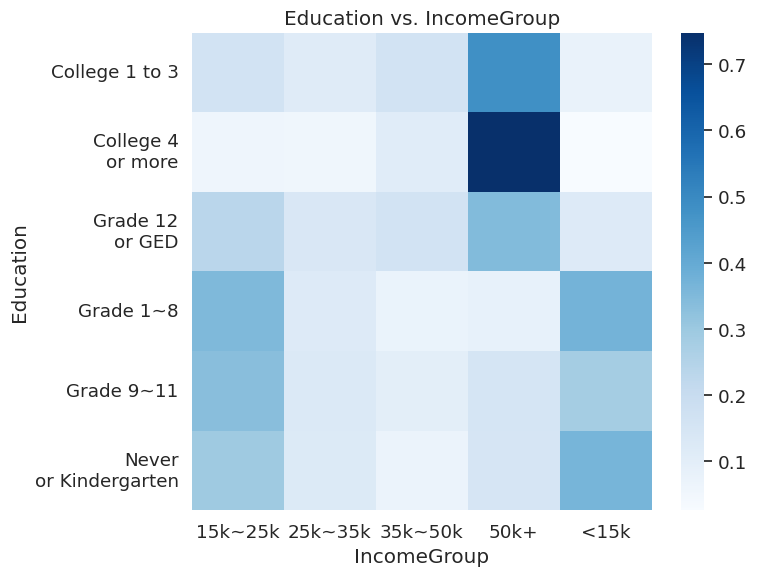

In [17]:
# (4) EDA: Demographic factors
# 4-6. Education × IncomeGroup Heatmap

# 1. Mapping: raw codes to labels
edu_map = {1: 'Never\nor Kindergarten', 2: 'Grade 1~8',
           3: 'Grade 9~11', 4: 'Grade 12\nor GED',
           5: 'College 1 to 3', 6: 'College 4\nor more'}

inc_map = {1: '<15k', 2: '15k~25k', 3: '25k~35k', 4: '35k~50k', 5: '50k+'}

df_htm = df_eda.copy()
df_htm['Education_label'] = df_htm['Education'].map(edu_map)
df_htm['IncomeGroup_label'] = df_htm['IncomeGroup'].map(inc_map)

# 2. Crosstab: Education vs. IncomeGroup
htm_ct = pd.crosstab(df_htm['Education_label'],
                     df_htm['IncomeGroup_label'],
                     normalize='index')
print(htm_ct)

# 3. Heatmap: Education vs. IncomeGroup
plt.figure(figsize=(8,6))
sns.heatmap(htm_ct, cmap='Blues', annot=False, cbar=True)

plt.title('Education vs. IncomeGroup')
plt.xlabel('IncomeGroup')
plt.ylabel('Education')
plt.tight_layout()
plt.show()


DepressionDiag    0
Exercise          0
SmokerStatus      0
HeavyDrink        0
Sex               0
AgeGroup          0
Race              0
Education         0
IncomeGroup       0
BMICat            0
MentalBadDays     0
SleepTime         0
CVD_total         0
dtype: int64
float64
| Variable       | Levels (codes)               |   Baseline (ref code) |
|:---------------|:-----------------------------|----------------------:|
| DepressionDiag | 1.0, 2.0                     |                     1 |
| Exercise       | 1.0, 2.0                     |                     1 |
| SmokerStatus   | 1.0, 2.0, 3.0, 4.0           |                     1 |
| HeavyDrink     | 1.0, 2.0                     |                     1 |
| Sex            | 1.0, 2.0                     |                     1 |
| AgeGroup       | 1.0, 2.0, 3.0, 4.0, 5.0, 6.0 |                     1 |
| Race           | 1.0, 2.0, 3.0, 4.0, 5.0, 6.0 |                     1 |
| Education      | 1.0, 2.0, 3.0, 4.0, 5.0, 6.0 |    

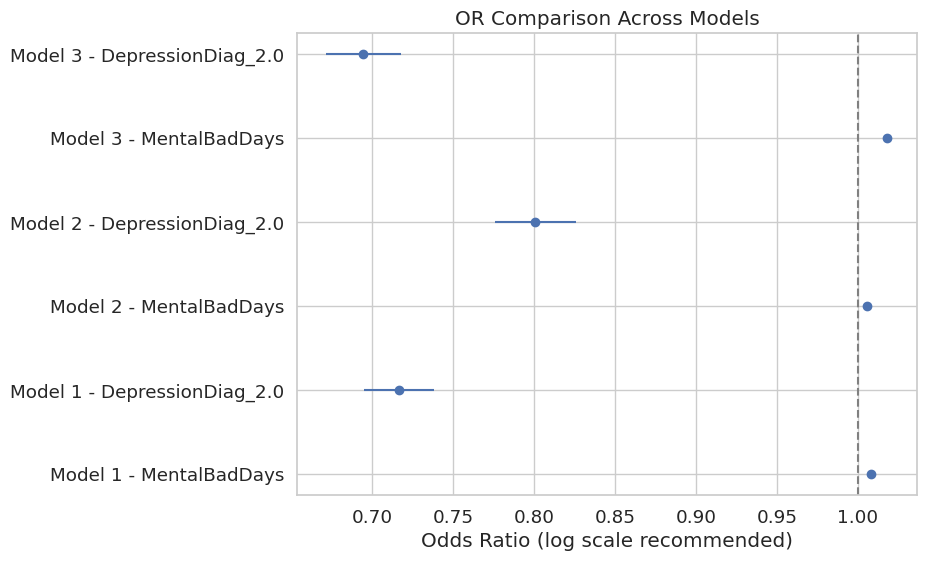

In [18]:
# (5) Logistic Regression
# 5-1. Data preparation and baseline information

# 1. Select variables for logistic regression
cat_vars_all = ['DepressionDiag', 'Exercise', 'SmokerStatus', 'HeavyDrink',
    'Sex', 'AgeGroup', 'Race', 'Education', 'IncomeGroup', 'BMICat']
cont_vars_all = ['MentalBadDays', 'SleepTime']
cols_logit = cat_vars_all + cont_vars_all + ['CVD_total']

df_logit = df_eda[cols_logit].copy()

# 2. Drop rows with any missing values in selected variables
df_logit = df_logit.dropna()
print(df_logit.isna().sum())

# 3. Define outcome variable
y = df_logit['CVD_total'].astype(float)
print(y.dtypes)

# 4. Baseline information for categorical variables
rows = []
for col in cat_vars_all:
    unique_vals = sorted(df_logit[col].dropna().unique())
    baseline = unique_vals[0]
    rows.append({'Variable': col,
        'Levels (codes)': ', '.join(str(v) for v in unique_vals),
        'Baseline (ref code)': baseline,})

baseline_df = pd.DataFrame(rows)
print(baseline_df.to_markdown(index=False))


# 5-2. Model 1 – Psychological only
# 1. Select predictors for Model 1
m1_cat_vars = ['DepressionDiag']
m1_cont_vars = ['MentalBadDays']

m1_x_cat = df_logit[m1_cat_vars].astype('category')
m1_x_cont = df_logit[m1_cont_vars]

# 2. Create dummy variables
m1_x_cat_dm = pd.get_dummies(m1_x_cat, drop_first=True)

# 3. Combine continuous + dummy predictors
x1 = pd.concat([m1_x_cont, m1_x_cat_dm], axis=1).astype(float)

# 4. Add intercept
x1 = sm.add_constant(x1)

print(x1.head())

# 5. Fit logistic regression (Model 1)
logit1 = sm.Logit(y, x1)
result1 = logit1.fit()
print(result1.summary())

# 6. Odds ratio (OR) table for Model 1
m1_params = result1.params
m1_conf = result1.conf_int()
m1_pvals = result1.pvalues

m1_or_table = pd.DataFrame({'OR': np.exp(m1_params),'2.5%': np.exp(m1_conf[0]),
    '97.5%': np.exp(m1_conf[1]),'p-value': m1_pvals})
print(m1_or_table)


# 5-3. Model 2 – Psychological + Behavioral
# 1. Select predictors for Model 2
m2_cat_vars = ['DepressionDiag', 'Exercise', 'HeavyDrink', 'SmokerStatus', 'BMICat']
m2_cont_vars = ['MentalBadDays', 'SleepTime']

m2_x_cat = df_logit[m2_cat_vars].astype('category')
m2_x_cont = df_logit[m2_cont_vars]

# 2. Create dummy variables
m2_x_cat_dm = pd.get_dummies(m2_x_cat, drop_first=True)

# 3. Combine continuous + dummy predictors
x2 = pd.concat([m2_x_cont, m2_x_cat_dm], axis=1).astype(float)

# 4. Add intercept
x2 = sm.add_constant(x2)

print(x2.head())

# 5. Fit logistic regression (Model 2)
logit2 = sm.Logit(y, x2)
result2 = logit2.fit()
print(result2.summary())

# 6. Odds ratio (OR) table for Model 2
m2_params = result2.params
m2_conf = result2.conf_int()
m2_pvals = result2.pvalues

m2_or_table = pd.DataFrame({'OR': np.exp(m2_params), '2.5%': np.exp(m2_conf[0]),
    '97.5%': np.exp(m2_conf[1]), 'p-value': m2_pvals})
print(m2_or_table)

# 5-4. Model 3 – Psychological + Behavioral + Demographic
# 1. Select predictors for Model 3
m3_cat_vars = cat_vars_all
m3_cont_vars = cont_vars_all

m3_x_cat = df_logit[m3_cat_vars].astype('category')
m3_x_cont = df_logit[m3_cont_vars]

# 2. Create dummy variables
m3_x_cat_dm = pd.get_dummies(m3_x_cat, drop_first=True)

# 3. Combine continuous + dummy predictors
x3 = pd.concat([m3_x_cont, m3_x_cat_dm], axis=1).astype(float)

# 4. Add intercept
x3 = sm.add_constant(x3)

print(x3.head())

# 5. Fit logistic regression (Model 3)
logit3 = sm.Logit(y, x3)
result3 = logit3.fit()
print(result3.summary())

# 6. Odds ratio (OR) table for Model 3
m3_params = result3.params
m3_conf = result3.conf_int()
m3_pvals = result3.pvalues

m3_or_table = pd.DataFrame({'OR': np.exp(m3_params), '2.5%': np.exp(m3_conf[0]),
    '97.5%': np.exp(m3_conf[1]), 'p-value': m3_pvals})
print(m3_or_table)


# 5-5. Summary of ORs for psychological variables across models
# 1. Create combined OR (95% CI) text column
m1_or = m1_or_table.copy()
m1_or['Model'] = 'Model 1'

m2_or = m2_or_table.copy()
m2_or['Model'] = 'Model 2'

m3_or = m3_or_table.copy()
m3_or['Model'] = 'Model 3'

or_all = pd.concat([m1_or, m2_or, m3_or])
or_all = or_all.reset_index().rename(columns={'index':'Variable'})
or_all = or_all[['Model', 'Variable', 'OR', '2.5%', '97.5%', 'p-value']]
or_all['OR (95% CI)'] = or_all.apply(
    lambda r: f"{r['OR']:.3f} ({r['2.5%']:.3f}–{r['97.5%']:.3f})", axis=1)

# 2. Select psychological variables of interest
psych_vars = ['MentalBadDays', 'DepressionDiag_2.0']
psych_or = or_all[or_all['Variable'].isin(psych_vars)]

# 3. Pivot to wide format: rows = Variable, columns = Model
psych_summary = psych_or.pivot(index='Variable', columns='Model', values='OR (95% CI)')
print(psych_summary.to_markdown())

# 5-6. OR plot for key psychological variables
plot_df = or_all[or_all['Variable'].isin(['MentalBadDays', 'DepressionDiag_2.0'])]

fig, ax = plt.subplots(figsize=(8,6))

y_pos = np.arange(len(plot_df))
ax.errorbar(plot_df['OR'], y_pos,
    xerr=[plot_df['OR'] - plot_df['2.5%'], plot_df['97.5%'] - plot_df['OR']],
    fmt='o')

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df['Model'] + ' - ' + plot_df['Variable'])

ax.axvline(1, color='grey', linestyle='--')
plt.xlabel('Odds Ratio (log scale recommended)')
plt.title('OR Comparison Across Models')
plt.show()
